In [60]:
using ComputationalHeatTransfer

In [61]:
# using Plots
using LaTeXStrings

In [62]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
# using JLD
using Plots
pyplot()  

Plots.PyPlotBackend()

In [63]:
using JLD2

In [64]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

# the plate code initialization

### Physical parameters

In [65]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.002)

### Geometry parameters

In [66]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [67]:
xlim = (-Lx/2,Lx/2) .* 1.1
ylim = (-Ly/2,Ly/2) .* 1.1
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.15)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

Δt = 1e-3

0.001

### Set up the boundary of the domain

In [68]:
bdry = Rectangle(Lx/2,Ly/2,1.5Δx)

Rectangular body with 368 points and half-lengths (0.0762,0.0324)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [69]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((-2inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((2inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = 0.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [70]:
y

222-element Array{Float64,1}:
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  0.002
  ⋮
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002
 -0.001618033988749895
 -0.0006180339887498949
  0.0006180339887498947
  0.0016180339887498947
  0.002

In [71]:
scatter(x,y)
plot!(xf,yf)

LoadError: [91mUndefVarError: xf not defined[39m

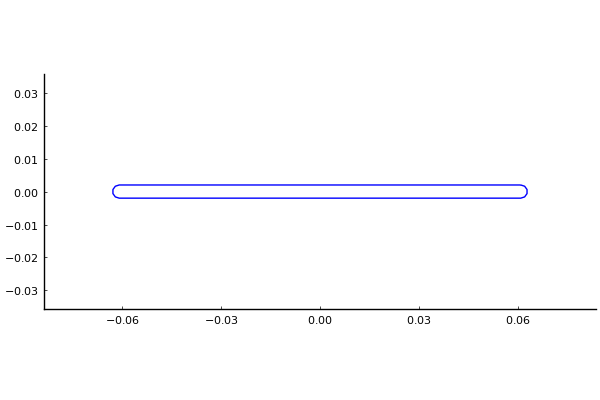

In [72]:
ds = 1.5Δx
nturn = 0.2
#pitch = 0.125
length_ohp = Lx*0.8
height = Ly*0.8
gap = 2*d
pitch = 0.1*length_ohp/(2*nturn+1)
x0, y0 = 0.0, 0.0
# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
x,y = construct_oneloop_curve(x0,y0,ds,length_ohp,gap,0.0)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [73]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [74]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=eparams,bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


#### Initialize state, and create the integrator

In [75]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [76]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


In [77]:
@time step!(integrator,1.0)
maximum(integrator.u[:])

115.643510 seconds (3.59 M allocations: 15.806 GiB, 5.08% gc time)


3.061183080317101

### Set the relative temperature back to [K]

In [78]:
T0 = 295.0 #[K]
integrator.u += T0 - integrator.u[1,1]

(Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

### Plotting temperature contours

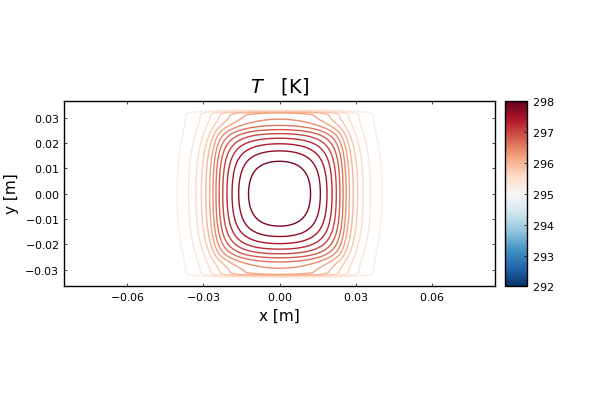

In [79]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clims=(T0-3.0,T0+3.0),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

### Plot the temperature along the OHP channel

In [80]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

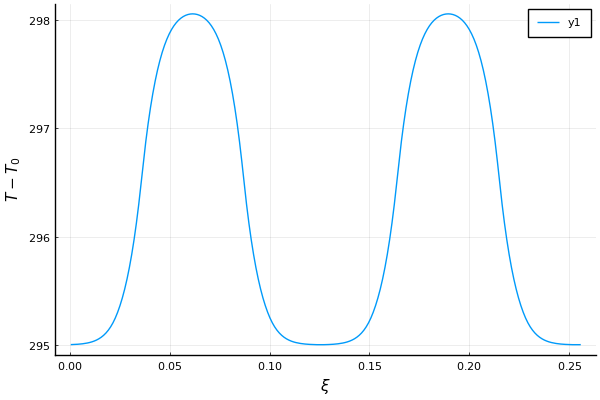

In [81]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [82]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [83]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  2.32E+02; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.64E+02;


In [116]:
    d = 6.56e-3 # dimensionless diameter
    L = 2.0+gap/length_ohp*pi  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [117]:
#     nucleatenum = 1
#     Xstations = sort(rand(nucleatenum).*L);
# #     boilingΔt = 0.05

Xstations = [0.5*L2D]

1-element Array{Float64,1}:
 0.5

In [118]:
tube = Tube(d,L,L2D,angle,closedornot);

In [119]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [120]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [121]:
# numofX=2
# Xps = sort(rand(2*numofX).*L);
# Xp1s = Xps[1:2:end];
# Xp2s = Xps[2:2:end];

# dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
# X0 = map(tuple,Xp1s,Xp2s);


In [148]:
N=numpts(ohp)
X0 = [(L2D*1/16, L2D*15/16)]
dXdt0 = [(0.0,0.0)]
ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [149]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(γ,Hδ,P,δ);

In [150]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [151]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [152]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [153]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [154]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [155]:
tspan = (0.0, 4.0);
dt_record = tspan[2] /100;
tstep=1e-3;

In [156]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

In [157]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, callback=cbst)

t: 0.0
u: 99-element Array{Float64,1}:
  0.0625
  0.9375
  0.0
  0.0
  1.2280705053844778
  0.0278
 -1.0e10
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [158]:
plate_hist = []
tube_hist  = []
currentsys = getcurrentsys(integrator_tube.u,sys0);

In [159]:

@time for t in tspan[1]:tstep:tspan[2]
    


    currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
    currentsys = getcurrentsys(integrator_tube.u,currentsys)
    
    
    nondi_qtmp = sys_to_heatflux(currentsys)
    qtmp = nondi_Q_to_Q*nondi_qtmp
    set_linesource_strength!(sys,qtmp)
    
    
    # reinitialize the integrator_plate to avoid some mysterious problems
    integrator_plate = init(deepcopy(integrator_plate.u),(integrator_plate.t,integrator_plate.t + tstep),sys)
    step!(integrator_plate,tstep, true)
    
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, SSPRK22(), callback=cbst, dt=1e-4);
    solve!(integrator_tube);
#     @time step!(integrator_tube, tstep*t_to_nondi_t)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.04000000000000003
0.08000000000000006
0.12000000000000009
0.16000000000000011
0.20000000000000015
0.24000000000000019
0.2800000000000002
0.32000000000000023
0.36000000000000026
0.4000000000000003
0.44000000000000034
0.48000000000000037
Boiled!0.14150000000000007
0.5200000000000004
0.5600000000000004
0.6000000000000004
0.6400000000000005
0.6800000000000005
0.7200000000000005
0.7600000000000006
0.8000000000000006
0.8400000000000006
0.8800000000000007
0.9200000000000007
0.9600000000000007
1.0000000000000007
1.0399999999999963
1.0799999999999919
1.1199999999999875
1.159999999999983
1.1999999999999786
1.2399999999999742
1.2799999999999698
1.3199999999999654
1.359999999999961
1.3999999999999566
1.4399999999999522
1.4799999999999478
1.5199999999999434
1.559999999999939
1.5999999999999346
1.6399999999999302
1.6799999999999258
1.7199999999999214
1.759999999999917
1.7999999999999126
1.8399999999999082
1.8799999999999037
1.9199999999998993
1.959999999999895
1.9999999999998905
2.0399999999998863

In [160]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

4.000999999999671


In [161]:
sysfinal = []
for i = 1:length(tube_hist)
    plate_hist[i].u += T0 - plate_hist[i].u[1,1]
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [162]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

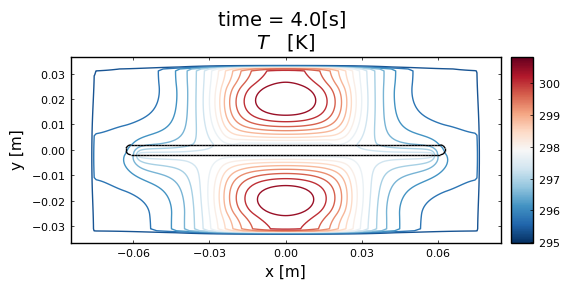

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
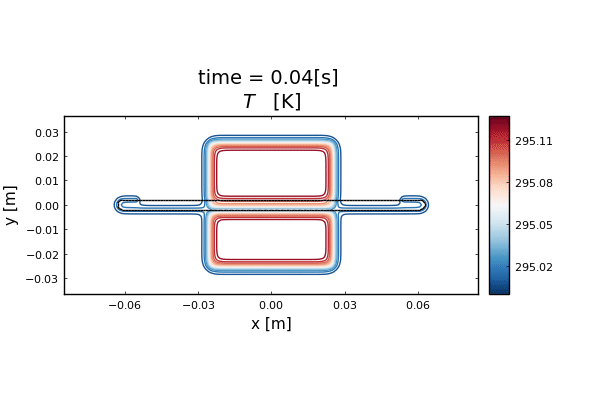

In [163]:
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1
Tmin = minimum(temperature(plate_hist[i])[:])
Tmax = maximum(temperature(plate_hist[i])[:])   
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T \quad [\mathrm{K}]"))
plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

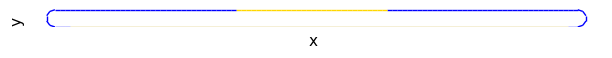

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
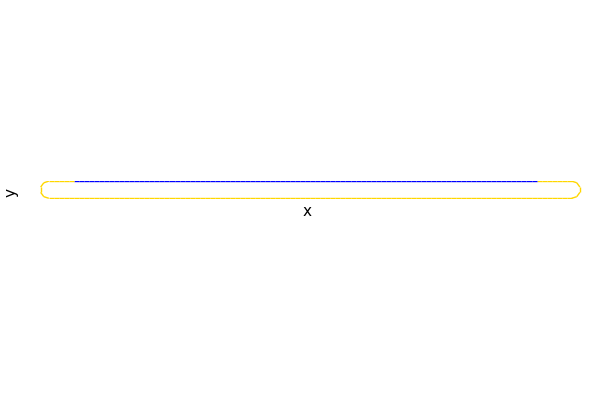

In [164]:
@gif for i=1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

# plot the OHP

In [224]:
sysfinal[end].liquid.Xp

2-element Array{Tuple{Float64,Float64},1}:
 (2.018595164040022, 0.3530245389222465)
 (0.6469754610777562, 1.0844754610777536)

In [226]:
sysfinal[end].mapping.P_interp_liquidtowall(0.4)

1.083528695426487

In [195]:
plot(sysfinal[end])

LoadError: [91mBoundsError: attempt to access 4-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64 at index [2.0277097473733554][39m

In [168]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii])
end

LoadError: [91mBoundsError: attempt to access 4-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64 at index [0.0078116983145773145][39m

# temperature difference with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [143]:
temp_evaporator = temperature(plate_hist[end])[110,48]

temp_condenser_1 = temperature(plate_hist[end])[44,48]
temp_condenser_2 = temperature(plate_hist[end])[end-44+1,48]
temp_condenser  = (temp_condenser_1+temp_condenser_2)/2

tempdiff_ASET = (temp_evaporator - temp_condenser) # K

0.4127077042807059

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [144]:
tempdiff_maximum = maximum(temperature(plate_hist[end]))-minimum(temperature(plate_hist[end])) # K

5.969489909452022

# thermal conductance with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [145]:
heater_power = 40 #watt
cond_ASET =  heater_power /tempdiff_ASET # W/K

96.92089482486068

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [146]:
heater_power = 40 #watt
cond_maximum =  heater_power /tempdiff_maximum # W/K

6.700740030846598

In [147]:
3+
3

6